In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.special import factorial2
import seaborn as sns
from viabel import all_bounds

# Normal Mixture Example

Here is a toy example where we use the approximating distribution
$$q = \mathcal{N}(0, 2)$$
for the "true" distribution
$$p = 0.5  \mathcal{N}(-1,1) + 0.5  \mathcal{N}(1,1),$$
where $\mathcal{N}(\mu, \sigma^2)$ denotes a normal distribution with mean $\mu$ and variance $\sigma^2$. 
Note that both distributions have mean 0 and variance 2. 

First, we construct functions to compute the log densities of $p$ and $q$

In [2]:
q_var = 5
q = norm(scale=np.sqrt(q_var))
log_q = q.logpdf
log_p = lambda x: np.logaddexp(norm.logpdf(x,loc=-2), norm.logpdf(x,loc=2)) - np.log(2)

Here is a plot of the densities of $p$ and $q$:

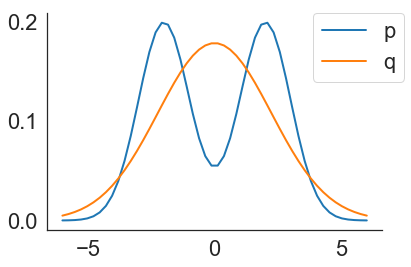

In [3]:
sns.set_style('white')
sns.set_context('notebook', font_scale=2, rc={'lines.linewidth': 2})
locs = np.linspace(-6,6)
plt.plot(locs, np.exp(log_p(locs)), label='p')
plt.plot(locs, np.exp(log_q(locs)), label='q')
plt.legend(bbox_to_anchor=(1.1, 1.05))
sns.despine()
plt.show()

Next, we construct functions to sample from $q$ and to compute, for even $\alpha \ge 2$, the central moments
$$\{\mathbb E_{X \sim q}(X^\alpha)\}^{1/\alpha} = 5^{1/2} \{(\alpha-1)!!\}^{1/\alpha},$$
which is a special case of the more general fact that 
$$\mathbb E_{X \sim \mathcal{N}(\mu, \sigma^2)}\{(X-\mu)^\alpha\} = (\alpha-1)!!\sigma^\alpha.$$

In [4]:
sample_q = q.rvs
q_moment_bound_fun = lambda order: factorial2(order-1)**(1/order) * np.sqrt(q_var)

Finally, we sample from $q$ and compute the log weights

In [5]:
n_samples = 50000
np.random.seed(918)
samples = sample_q(n_samples)
log_weights = log_p(samples) - log_q(samples)

We can compute the bounds on the Wasserstein distances, 2-divergence, and mean/standard deviation/variance errors in many different ways, depending on what information is available.

The simplest way is to use only the log weights and the samples:

In [6]:
all_bounds(log_weights, samples)

log norm bound = -0.24558833727824106


/Users/jhuggins/Dropbox (MIT)/Research/Projects/viabel/viabel/bounds.py:177: UserWarning: significant Monte Carlo error when computing CUBO (mean = 0.3881736695498691, standard deviation = 0.001554002294407435)
  warn(msg)
/Users/jhuggins/Dropbox (MIT)/Research/Projects/viabel/viabel/bounds.py:177: UserWarning: significant Monte Carlo error when computing ELBO (mean = -0.24558833727824106, standard deviation = 0.004127395087117064)
  warn(msg)


{'W1': 4.789727652359284,
 'W2': 6.083597052195541,
 'mean_error': 4.789727652359284,
 'std_error': 11.752607018903436,
 'var_error': 232.36376169439845,
 'd2': 0.7681085661288798}

Currently there is a warning when the Monte Carlo error is estimated to be greater than 0.001. 

We can obtain tighter, more accurate bounds using other available information.
For example, we can pass in the known variance of $q$ rather than getting a Monte Carlo estimate.
Since we also know that the log normalization constant for our `log_p` function is zero, we can get a tighter bound by using this information.

In [7]:
all_bounds(log_weights, samples, q_var=q_var, log_norm_bound=0)

{'W1': 2.5167408539529807,
 'W2': 4.409854702385317,
 'mean_error': 2.5167408539529807,
 'std_error': 8.51918509443254,
 'var_error': 129.84305190282245,
 'd2': 0.2769318915723977}

Rather than getting a Monte Carlo estimate of the central moments of $q$, we can use a known upper bound on (or exact value) for this quantity. In this case, we use `q_moment_bound_fun`. If we pass in values for `moment_bound_fn` and `q_var`, then we don't need to include the `samples` argument. 

In [8]:
all_bounds(log_weights, moment_bound_fn=q_moment_bound_fun, q_var=q_var)

log norm bound = -0.24558833727824106


{'W1': 4.807671077788009,
 'W2': 6.102463440007818,
 'mean_error': 4.807671077788009,
 'std_error': 11.789054081376761,
 'var_error': 233.8316215554741,
 'd2': 0.7681085661288798}